# Imports and environment


In [70]:
import sys
import os
import warnings
import mne

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_SHIN_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from mne.decoding import CSP, PSDEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import scripts.multi_task.linear as linear
import scripts.multi_task.linear_data_selection as linear_ds
from scripts.features_extract.welch import extract_welch_features
from eeg_logger import logger

import moabb
from moabb.datasets import BNCI2014_004
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset


In [71]:
dataset = BNCI2014_004()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery(channels=None)
data = dataset.get_data(subjects=[1])
data[1]["4test"]["0"]

<RawArray | 7 x 474363 (1897.5 s), ~25.3 MiB, data loaded>

# Prepare train and test data

The data is organised as follows:

- **X_all** - all data from epochs regarding left/right hand movement
- **y_all** - all labels from epochs regarding left/right hand movement
- **X_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing 4 sessions of each patient.
- **y_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing sessions' labels for each patient
- **X_test** - array of shape (n_subjects, ) where each element represents data from the last session of each subject
- **y_test** - array of shape (n_subjects, ) where each element represents labels from the last session of each subject


In [87]:
X_all, y_all, metadata = paradigm.get_data(dataset, subjects=dataset.subject_list, return_epochs=False)
subjects = metadata["subject"].unique()
sessions = metadata["session"].unique()

X_train = np.empty(len(subjects), dtype=object)
X_test = np.empty(len(subjects), dtype=object)
y_train = np.empty(len(subjects), dtype=object)
y_test = np.empty(len(subjects), dtype=object)
label_map = {"left_hand": -1, "right_hand": 1}

for idx, subject in enumerate(subjects):

    sess_1_mask = (metadata["subject"] == subject) & (metadata["session"] == "0train")
    sess_2_mask = (metadata["subject"] == subject) & (metadata["session"] == "1train")
    sess_3_mask = (metadata["subject"] == subject) & (metadata["session"] == "2train")
    sess_4_mask = (metadata["subject"] == subject) & (metadata["session"] == "3test")
    sess_5_mask = (metadata["subject"] == subject) & (metadata["session"] == "4test")

    X_sess_1 = X_all[sess_1_mask]
    y_sess_1 = y_all[sess_1_mask]
    X_sess_2 = X_all[sess_2_mask]
    y_sess_2 = y_all[sess_2_mask]
    X_sess_3 = X_all[sess_3_mask]
    y_sess_3 = y_all[sess_3_mask]
    X_sess_4 = X_all[sess_4_mask]
    y_sess_4 = y_all[sess_4_mask]
    X_sess_5 = X_all[sess_5_mask]
    y_sess_5 = y_all[sess_5_mask]

    X_sess_1_feat = extract_welch_features(X_sess_1)
    y_sess_1 = np.array([label_map[label] for label in y_sess_1])
    X_sess_2_feat = extract_welch_features(X_sess_2)
    y_sess_2 = np.array([label_map[label] for label in y_sess_2])
    X_sess_3_feat = extract_welch_features(X_sess_3)
    y_sess_3 = np.array([label_map[label] for label in y_sess_3])
    X_sess_4_feat = extract_welch_features(X_sess_4)
    y_sess_4 = np.array([label_map[label] for label in y_sess_4])
    X_sess_5_feat = extract_welch_features(X_sess_5)
    y_sess_5 = np.array([label_map[label] for label in y_sess_5])

    X_subject_train = np.empty(4, dtype=object)
    X_subject_train[0] = X_sess_1_feat.T
    X_subject_train[1] = X_sess_2_feat.T
    X_subject_train[2] = X_sess_3_feat.T
    X_subject_train[3] = X_sess_4_feat.T
    y_subject_train = np.empty(4, dtype=object)
    y_subject_train[0] = y_sess_1.reshape(-1, 1)
    y_subject_train[1] = y_sess_2.reshape(-1, 1)
    y_subject_train[2] = y_sess_3.reshape(-1, 1)
    y_subject_train[3] = y_sess_4.reshape(-1, 1)

    X_train[idx] = X_subject_train
    y_train[idx] = y_subject_train
    X_test[idx] = X_sess_5_feat.T
    y_test[idx] = y_sess_5.reshape(-1, 1)

2025-07-11 11:58:10,006 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-11 11:58:10,181 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-11 11:58:10,407 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-11 11:58:10,633 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-11 11:58:10,863 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-11 11:58:11,049 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-11 11:58:11,224 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-11 11:58:11,448 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-11 11:58:11,616 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-11 11:58:11,842 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-11 11:58:12,017 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-11 11:58:12,188 - INFO - Welch features extracted, vector

# Testing classifier across sessions (Algorithm 1)

First, classifier learns basic prior info based on four sessions of current patient.  
This creates a shared model with prior info.  
Then shared model is tested on the fifth session of current patient.


In [88]:
accuracies = []
algorithm_1_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf = linear.MultiTaskLinearClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc)
    algorithm_1_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_1_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_1_results["accuracies"] = accuracies

2025-07-11 11:58:23,115 - INFO - Iteration 1, error = 14.556872163411947
2025-07-11 11:58:23,118 - INFO - Iteration 2, error = 2.57885230295644
2025-07-11 11:58:23,121 - INFO - Iteration 3, error = 0.8249000760271266
2025-07-11 11:58:23,123 - INFO - Iteration 4, error = 0.6372327661737541
2025-07-11 11:58:23,126 - INFO - Iteration 5, error = 0.5814368198556047
2025-07-11 11:58:23,129 - INFO - Iteration 6, error = 0.5848963271067895
2025-07-11 11:58:23,131 - INFO - Iteration 7, error = 0.5786012578002577
2025-07-11 11:58:23,134 - INFO - Iteration 8, error = 0.45405126523375605
2025-07-11 11:58:23,136 - INFO - Iteration 9, error = 0.18961984221819622
2025-07-11 11:58:23,138 - INFO - Iteration 10, error = 0.027275285690717986
2025-07-11 11:58:23,141 - INFO - Iteration 11, error = 0.009638131650134383
2025-07-11 11:58:23,143 - INFO - Iteration 12, error = 0.005643315753375151
2025-07-11 11:58:23,145 - INFO - Iteration 13, error = 0.0034773981805798263
2025-07-11 11:58:23,147 - INFO - Itera

# Plot results (Algorithm 1)


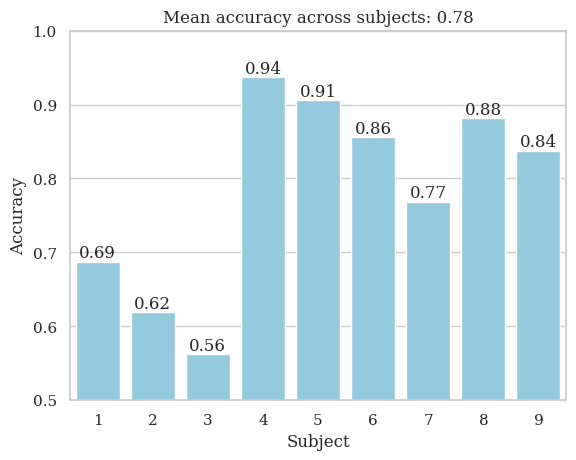

In [140]:
axes = sns.barplot(data=algorithm_1_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.5, 1)
axes.bar_label(axes.containers[0], fmt="%.2f")
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_1_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")
plt.show()

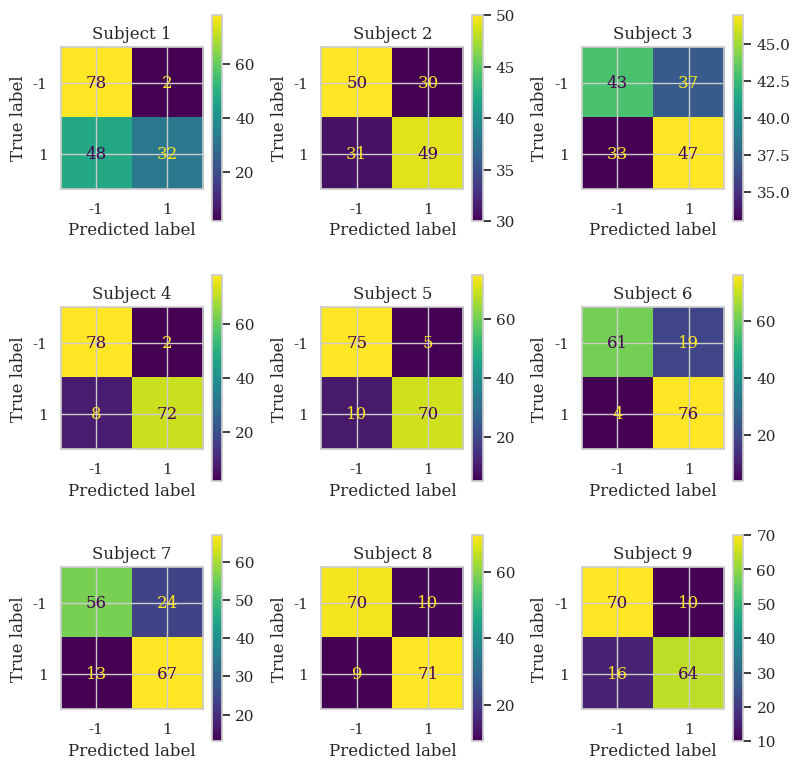

In [189]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Subject {subj_idx}")
plt.tight_layout()

# Testing classifier across sessions (Algorithm 2)

First, shared model is acquired the same way as for previous testing pipeline.  
Next, the fifth session is split into train and test data.  
The train data is used to calculate weight vector for this task and select prior vectors that match the new vector the most.  
Finally, the classifier is tested on the remaining data from fifth session.


In [146]:
def split_test_session(X: np.ndarray, y: np.ndarray):
    from sklearn.model_selection import train_test_split

    X_adapt, X_eval, y_adapt, y_eval = train_test_split(X.T, y, train_size=0.5, shuffle=True, random_state=42)
    return X_adapt.T, X_eval.T, y_adapt, y_eval


accuracies = []
algorithm_2_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):

    clf = linear_ds.MultiTaskLinearWithSelectionClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])

    X_adapt, X_eval, y_adapt, y_eval = split_test_session(X_test[idx], y_test[idx])
    clf.fit(X_adapt, y_adapt)
    acc, y_pred = clf.score(X_eval, y_eval)

    accuracies.append(acc)
    algorithm_2_results[f"subj_{idx+1}_test_labels"] = y_eval
    algorithm_2_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_2_results["accuracies"] = accuracies

2025-07-11 12:24:10,462 - INFO - Iteration 1, error = 14.556872163411947
2025-07-11 12:24:10,465 - INFO - Iteration 2, error = 2.57885230295644
2025-07-11 12:24:10,468 - INFO - Iteration 3, error = 0.8249000760271266
2025-07-11 12:24:10,471 - INFO - Iteration 4, error = 0.6372327661737541
2025-07-11 12:24:10,473 - INFO - Iteration 5, error = 0.5814368198556047
2025-07-11 12:24:10,476 - INFO - Iteration 6, error = 0.5848963271067895
2025-07-11 12:24:10,480 - INFO - Iteration 7, error = 0.5786012578002577
2025-07-11 12:24:10,483 - INFO - Iteration 8, error = 0.45405126523375605
2025-07-11 12:24:10,485 - INFO - Iteration 9, error = 0.18961984221819622
2025-07-11 12:24:10,487 - INFO - Iteration 10, error = 0.027275285690717986
2025-07-11 12:24:10,490 - INFO - Iteration 11, error = 0.009638131650134383
2025-07-11 12:24:10,492 - INFO - Iteration 12, error = 0.005643315753375151
2025-07-11 12:24:10,495 - INFO - Iteration 13, error = 0.0034773981805798263
2025-07-11 12:24:10,497 - INFO - Itera

# Plot results (Algorithm 2)


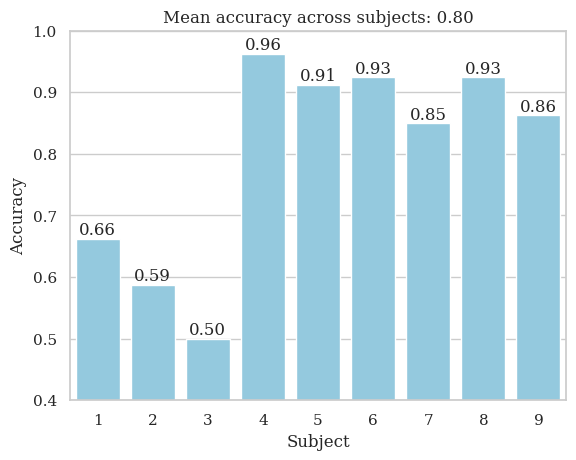

In [147]:
axes = sns.barplot(data=algorithm_2_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.4, 1)
axes.bar_label(axes.containers[0], fmt="%.2f")
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_2_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")
plt.show()

# Testing classifier across subjects (Algorithm 1)

Here, classifier is used on shared data between subjects. The pipeline is build like this:

- use all sessions from current subject (Si) and 4 sessions from next subject (Sm) as training data to build shared model
- test the model on fifth session data of subject Sm


In [ ]:
cross_subject_results = []
for idx, subj in enumerate(subjects):

    if idx == len(subjects) - 1:
        break

    X_si_train = X_train[idx]
    y_si_train = y_train[idx]
    X_si_test = X_test[idx]
    y_si_test = y_test[idx]
    X_si_test_wrapped = np.empty(1, dtype=object)
    X_si_test_wrapped[0] = X_si_test
    y_si_test_wrapped = np.empty(1, dtype=object)
    y_si_test_wrapped[0] = y_si_test
    X_si_all = np.concatenate((X_si_train, X_si_test_wrapped), axis=0)
    y_si_all = np.concatenate((y_si_train, y_si_test_wrapped), axis=0)

    X_sm_train = X_train[idx + 1]
    y_sm_train = y_train[idx + 1]

    X_cross_subj_sessions = np.concatenate((X_si_all, X_sm_train), axis=0)
    y_cross_subj_sessions = np.concatenate((y_si_all, y_sm_train), axis=0)

    clf = linear_ds.MultiTaskLinearWithSelectionClassifier(regularization=0.1, cov_flag="l2-trace", zero_mean=False)
    clf.fit_sessions(X_cross_subj_sessions, y_cross_subj_sessions)

    X_sm_test_session = X_test[idx + 1]
    y_sm_test_session = y_test[idx + 1]

    acc, y_pred = clf.score(X_sm_test_session, y_sm_test_session)

    cross_subject_results.append(
        {
            "subject_Si": f"S{subjects[idx]}",
            "subject_Sm": f"S{subjects[idx+1]}",
            "accuracy": acc,
        }
    )

    logger.info(
        f"Training on S{subjects[idx]}[:5] + S{subjects[idx+1]}[:4], test on S{subjects[idx+1]}[5] acc = {acc:.2f}"
    )

2025-07-11 13:41:59,297 - INFO - Iteration 1, error = 21.96450781761838
2025-07-11 13:41:59,301 - INFO - Iteration 2, error = 9.76632008823681
2025-07-11 13:41:59,305 - INFO - Iteration 3, error = 2.2952904343344644
2025-07-11 13:41:59,308 - INFO - Iteration 4, error = 1.4997274470035646
2025-07-11 13:41:59,313 - INFO - Iteration 5, error = 0.8104593267122829
2025-07-11 13:41:59,317 - INFO - Iteration 6, error = 0.4976046818082226
2025-07-11 13:41:59,321 - INFO - Iteration 7, error = 0.4887875962483689
2025-07-11 13:41:59,325 - INFO - Iteration 8, error = 0.54561194026122
2025-07-11 13:41:59,328 - INFO - Iteration 9, error = 0.6278444034025984
2025-07-11 13:41:59,332 - INFO - Iteration 10, error = 0.7091271354825458
2025-07-11 13:41:59,336 - INFO - Iteration 11, error = 0.70661071763448
2025-07-11 13:41:59,341 - INFO - Iteration 12, error = 0.49092868610990376
2025-07-11 13:41:59,344 - INFO - Iteration 13, error = 0.16147703015941245
2025-07-11 13:41:59,348 - INFO - Iteration 14, error

# Plot cross-subject accuracy (Algorithm 1)


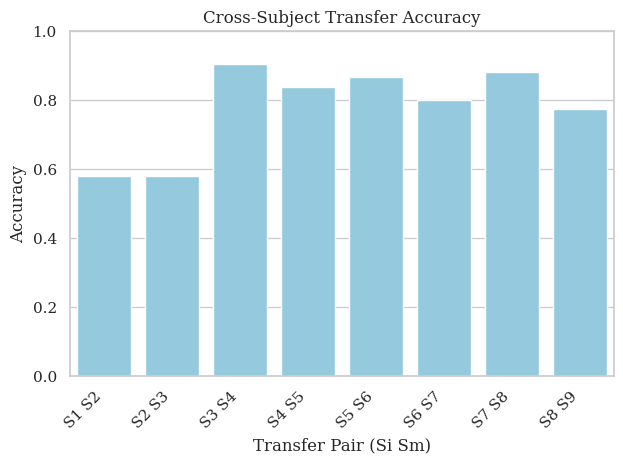

In [187]:
df = pd.DataFrame(cross_subject_results)
df["transfer_pair"] = df["subject_Si"] + " " + df["subject_Sm"]

axes = sns.barplot(data=df, x="transfer_pair", y="accuracy", color="skyblue")
axes.set_ylim(0, 1)
axes.set_title("Cross-Subject Transfer Accuracy")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Transfer Pair (Si Sm)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()